### Übungsblatt 10 - Rubin Mehralivand, Luis Schneck

In [284]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from abc import ABC, abstractmethod

In [261]:
def f(t: float, y: np.array):
    k1 = 4*10**-2
    k2 = 3*10**7
    k3 = 10*+4
    r = np.ndarray(3)
    r[0] = -k1 * y[0] + k3 * y[1] * y[2]
    r[1] = k1 * y[0] - k2 * y[1]**2 - k3 * y[1] * y[2]
    r[2] = k2 * y[1]**2

    return r

### a)
Wir berechnen die Jacobi-Matrix durch finite Differenzen. Danach berechnen wir die eigenwerte und bestimmen die Konditionierung der Jacobi-Matrix durch:
$$\kappa(t) = \frac{\max_{Re(\lambda) < 0}(Re(\lambda))}{min_{Re(\lambda) < 0}(Re(\lambda))}\approx 1.67 \cdot 10^{21} >> 1$$
Somit ist die Matrix schlecht konditioniert, dies liegt wahrscheinlich an der großen Variation der Werte ($\approx 10^6$) in der Matrix an dem Punkt.

In [285]:
def calculate_jacobian(p: np.ndarray) -> np.array:
    jacobian = np.zeros((3,3))
    fx0 = f(0, p)
    h = 1e-8
    for i in range(3):
        dp = np.array(p)
        dp[i] += h
        diff = (f(0, dp) - fx0) / h
        jacobian[:, i] = diff

    return jacobian


jacobian = calculate_jacobian(np.array([0.9,10**-5,0.1]))
print(f'Jacobi Matrix: \n {jacobian}')
eigvals = np.linalg.eigvals(jacobian)
print(f"Eigenwerte: {eigvals}")

cond = max(np.abs(eigvals))/min(np.abs(eigvals))
print(f"Konditionszahl: {cond}")


Jacobi Matrix: 
 [[-3.99999998e-02  4.00000000e+00  4.00000172e-04]
 [ 3.99999998e-02 -6.04300000e+02 -4.00000172e-04]
 [ 0.00000000e+00  6.00300000e+02  0.00000000e+00]]
Eigenwerte: [-6.04299867e+02 -4.01325920e-02 -3.62652980e-19]
Konditionszahl: 1.666330903163444e+21


In [263]:
class Einschrittmethode(ABC):
    def __init__(self, f: callable, t0: float, u0: np.ndarray, t_end: float):
        self.f = f
        self.t0 = t0
        self.u0 = u0
        self.t_end = t_end

    @abstractmethod
    def step(self, h: float):
        pass

    def integrate(self, h: float) -> tuple:
        n = int(self.t_end/h)
        ts = np.zeros(n)
        ys = np.zeros((n,3))
        ys[0] = self.u0
        ts[0] = self.t0

        for i in range(1, n):
            self.step(h)
            ys[i] = self.u0
            ts[i] = self.t0

        return ts, ys

class Eulerverfahren(Einschrittmethode):
    def step(self, h: float):
        self.u0 += h * self.f(self.t0, self.u0)
        self.t0 += h

class ImpliziterEuler(Einschrittmethode):
    def step(self, h: float):
        self.t0 += h

        def newton(u_next: float):
            return u_next - self.u0 - h * self.f(self.t0, u_next)

        u_test = np.array([self.u0])    # Konversion zu (nd-)array um Warnings zu vermeiden
        self.u0 = scipy.optimize.fsolve(newton, u_test)

Die Auswertung bei $10^{-3}$ ist in noch in Ordnung, allerdings sind die Werte vom expliziten und impliziten Eulerverfahren anders.

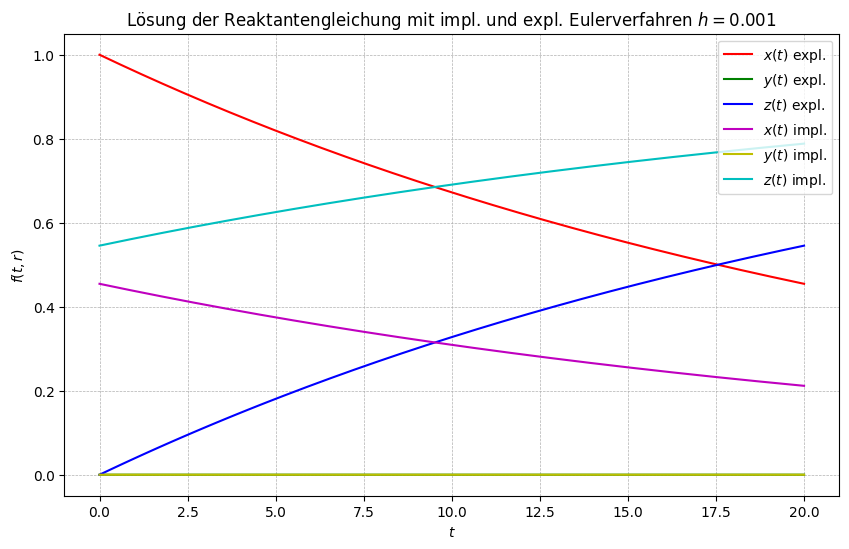

In [264]:
initval = np.array([1.0,0.0,0.0])
h = 10**-3
T, expl = Eulerverfahren(f, 0, initval, 20).integrate(h)
T, impl = ImpliziterEuler(f, 0, initval, 20).integrate(h)

plt.figure(figsize=(10, 6))
plt.plot(T, expl[:,0], label='$x(t)$ expl.', color='r')
plt.plot(T, expl[:,1], label='$y(t)$ expl.', color='g')
plt.plot(T, expl[:,2], label='$z(t)$ expl.', color='b')
plt.plot(T, impl[:,0], label='$x(t)$ impl.', color='m')
plt.plot(T, impl[:,1], label='$y(t)$ impl.', color='y')
plt.plot(T, impl[:,2], label='$z(t)$ impl.', color='c')
plt.xlabel("$t$")
plt.ylabel("$f(t, r)$")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.title(f"Lösung der Reaktantengleichung mit impl. und expl. Eulerverfahren $h = {h}$")
plt.show()

Eine kleine Variation der Schrittweite führt zu einer Explosion der Werte beim expliziten Eulerverfahren, wahrscheinlich weil da das $h$ außerhalb des Stabilitätsgebietes liegt.

/var/folders/y0/8__g3_zx78n1fhp1n15289xr0000gq/T/ipykernel_3402/3530293538.py:6: RuntimeWarning: overflow encountered in scalar multiply
  r[0] = -k1 * y[0] + k3 * y[1] * y[2]
/var/folders/y0/8__g3_zx78n1fhp1n15289xr0000gq/T/ipykernel_3402/3530293538.py:7: RuntimeWarning: overflow encountered in scalar power
  r[1] = k1 * y[0] - k2 * y[1]**2 - k3 * y[1] * y[2]
/var/folders/y0/8__g3_zx78n1fhp1n15289xr0000gq/T/ipykernel_3402/3530293538.py:7: RuntimeWarning: overflow encountered in scalar multiply
  r[1] = k1 * y[0] - k2 * y[1]**2 - k3 * y[1] * y[2]
/var/folders/y0/8__g3_zx78n1fhp1n15289xr0000gq/T/ipykernel_3402/3530293538.py:7: RuntimeWarning: invalid value encountered in scalar subtract
  r[1] = k1 * y[0] - k2 * y[1]**2 - k3 * y[1] * y[2]
/var/folders/y0/8__g3_zx78n1fhp1n15289xr0000gq/T/ipykernel_3402/3530293538.py:8: RuntimeWarning: overflow encountered in scalar power
  r[2] = k2 * y[1]**2


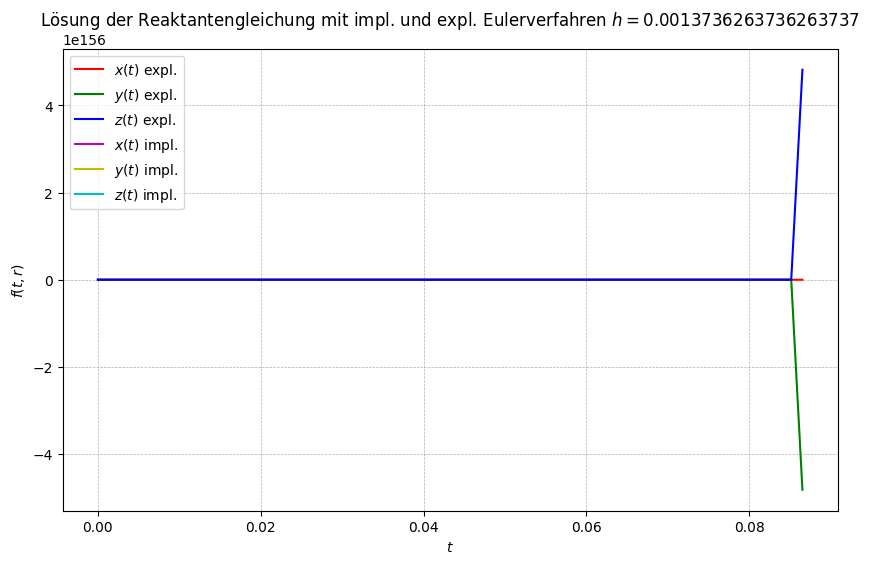

In [283]:
initval = np.array([1.0,0.0,0.0])
h = 1/728   # Genau hier explodiert die Gleichung
T, expl = Eulerverfahren(f, 0, initval, 20).integrate(h)
T, impl = ImpliziterEuler(f, 0, initval, 20).integrate(h)

plt.figure(figsize=(10, 6))
plt.plot(T, expl[:,0], label='$x(t)$ expl.', color='r')
plt.plot(T, expl[:,1], label='$y(t)$ expl.', color='g')
plt.plot(T, expl[:,2], label='$z(t)$ expl.', color='b')
plt.plot(T, impl[:,0], label='$x(t)$ impl.', color='m')
plt.plot(T, impl[:,1], label='$y(t)$ impl.', color='y')
plt.plot(T, impl[:,2], label='$z(t)$ impl.', color='c')
plt.xlabel("$t$")
plt.ylabel("$f(t, r)$")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.title(f"Lösung der Reaktantengleichung mit impl. und expl. Eulerverfahren $h = {h}$")
plt.show()